### Use cv to determine good parameters for iterations and learning rate

In [25]:
import pandas as pd
import numpy as np
from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor
import shap
shap.initjs()
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt


In [26]:
TARGET_COL = 'diabetes_mellitus'
cat_cols = ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']

def target_encode(var, dv, weight = 36):
    mean = dv.mean()
    true_weight = weight * max(1, mean/(1-mean))
    agg = dv.groupby(var,dropna=False).agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    return (counts * means + true_weight) / (counts + true_weight/mean)

def target_encode_train_test(var_train, dv_train, var_test, weight = 36):
    encode_key = target_encode(var_train,dv_train,weight)
    return var_train.map(encode_key), var_test.map(encode_key).fillna(dv_train.mean())

In [67]:
train = pd.read_csv('Data/train_0211_2.csv')
test = pd.read_csv('Data/test_0211_2.csv')
test[TARGET_COL] = -1
train['dataset_label'] = 0
test['dataset_label'] = 1
train[cat_cols] = train[cat_cols].fillna('')
test[cat_cols] = test[cat_cols].fillna('')

In [68]:
combined = pd.concat([train,test])
vars_to_encode = ['icu_id','apache_3j_diagnosis']
features_to_ignore = vars_to_encode+['hospital_id','encounter_id']
features_to_ignore.remove('apache_3j_diagnosis')
trainX, validX, trainY, validY = train_test_split(
    combined.drop(['dataset_label',TARGET_COL], axis=1), combined.dataset_label
    ,test_size=0.2, stratify=combined.dataset_label, random_state=86331)

In [69]:
av_train = Pool(
    data=trainX,
    label=trainY,
    cat_features = cat_cols
)

av_test = Pool(
    data=validX,
    label=validY,
    cat_features = cat_cols
)

In [74]:
av_params = {
    'eval_metric': 'AUC',
    'ignored_features': ['hospital_id','encounter_id','icu_id'#,'d1_mbp_invasive_min','d1_mbp_invasive_max'
                        ],
    'iterations': 100,
    'verbose': 50,
}

In [75]:
av_model = CatBoostClassifier(**av_params)
av_fitted = av_model.fit(av_train,eval_set=av_test,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.274448
0:	test: 0.5128711	best: 0.5128711 (0)	total: 141ms	remaining: 14s
50:	test: 0.6993226	best: 0.6994681 (49)	total: 6.25s	remaining: 6.01s
99:	test: 0.7296658	best: 0.7296658 (99)	total: 12s	remaining: 0us

bestTest = 0.7296658031
bestIteration = 99



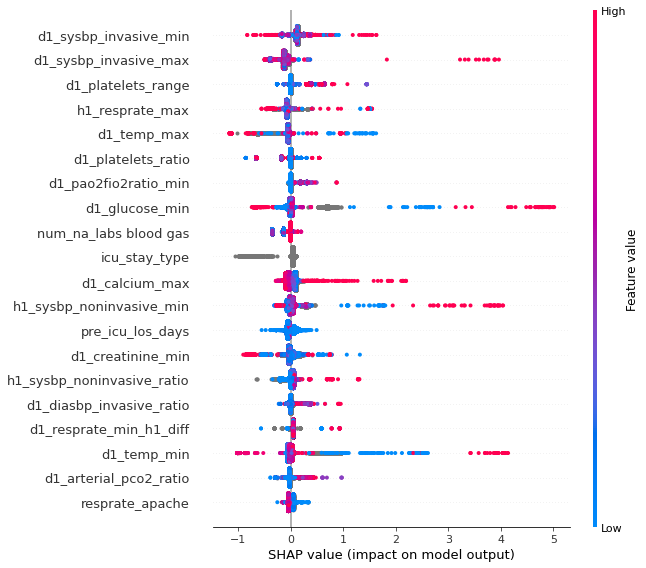

In [76]:
explainer = shap.TreeExplainer(av_model)
shap_values_train = explainer.shap_values(av_train)
shap.summary_plot(shap_values_train, trainX)

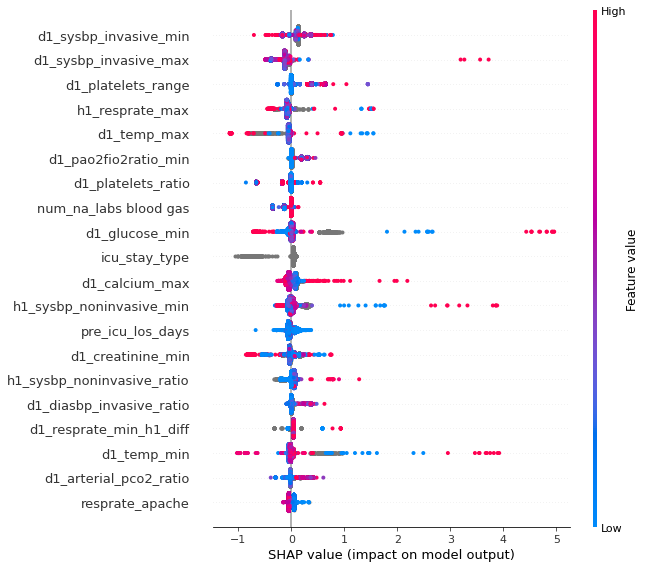

In [77]:
shap_values_test = explainer.shap_values(av_test)
shap.summary_plot(shap_values_test, validX)

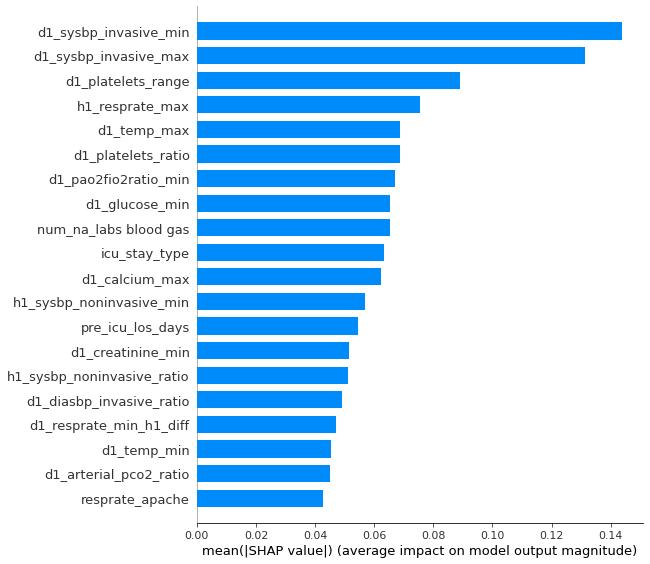

In [78]:
shap.summary_plot(shap_values_train, features=av_train, feature_names=trainX.columns, plot_type='bar')

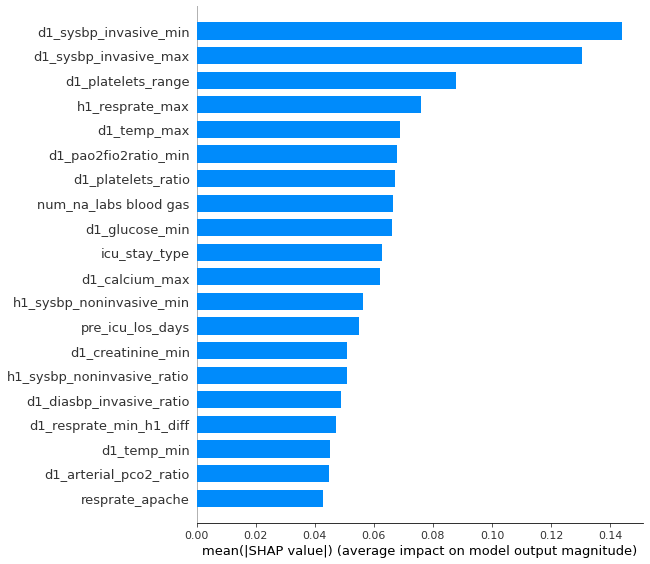

In [79]:
shap.summary_plot(shap_values_test, features=av_test, feature_names=validX.columns, plot_type='bar')

In [12]:
# kf = KFold(n_splits = 5, random_state = 1, shuffle = True)
# combined['dataset_pred'] = -1
# for i, (train_index, test_index) in enumerate(kf.split(combined)):
#     # Create train/test data
#     print( "\nFold ", i)
#     #print(combined.loc[combined.index[test_index],'cv_pred'])
#     kf_train = Pool(
#         data=combined_X.iloc[train_index],
#         label=combined_Y.iloc[train_index],
#         cat_features=cat_cols
#     )
#     kf_test_X = combined_X.iloc[test_index]
#     kf_test_Y = combined_Y.iloc[test_index]
#     # run model
#     av_kfold_fitted = av_model.fit(kf_train)
#     pred = av_kfold_fitted.predict_proba(kf_test_X)[:,1]
#     print("AUC = ", roc_auc_score(kf_test_Y, pred))
#     combined.loc[combined.index[test_index],'dataset_pred'] = pred
# print("Overall AUC = ", roc_auc_score(combined_Y, combined.dataset_pred))

In [13]:
combined['dataset_pred'] = av_fitted.predict_proba(combined_X)[:,1]

In [14]:
combined.groupby('dataset_label')['dataset_pred'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset_label,,,,,,,,
0,125139.0,0.056993,0.036164,0.000013,0.032838,0.053476,0.073327,0.61302
1,10234.0,0.304685,0.306532,0.015344,0.090451,0.149050,0.401500,1.00000


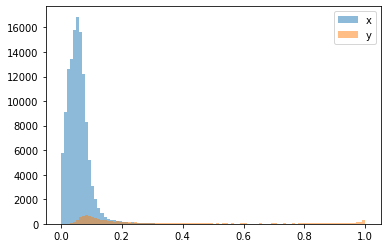

In [15]:
bins = np.linspace(0,1,101)
plt.hist(combined.loc[combined.dataset_label == 0,'dataset_pred'], bins, alpha=0.5, label='x')
plt.hist(combined.loc[combined.dataset_label == 1,'dataset_pred'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

In [29]:
train_processed = combined[combined.dataset_label == 0].drop('dataset_label',axis=1)
test_processed = combined[combined.dataset_label == 1].drop('dataset_label',axis=1)

In [31]:
test_processed.groupby(pd.cut(test_processed.dataset_pred,test_processed.dataset_pred.quantile(np.linspace(0,1,6))))['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset_pred,,,,,,,,
"(0.0153, 0.0836]",2046.0,62.797165,16.285395,19.0,53.0,64.0,76.0,89.0
"(0.0836, 0.119]",2047.0,61.199805,17.345566,18.0,51.0,64.0,74.5,89.0
"(0.119, 0.205]",2046.0,61.534213,17.582848,18.0,51.0,64.0,75.0,89.0
"(0.205, 0.568]",2047.0,61.393258,17.368701,18.0,51.0,64.0,75.0,89.0
"(0.568, 1.0]",2047.0,67.337079,19.759767,18.0,54.0,70.0,84.0,96.0


In [19]:
train_processed[['encounter_id','dataset_preds']].to_csv('Data/dataset_preds.csv',index=False)